In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from pathlib import Path

plt.style.use('style')

In [2]:
# Ruta a Figures desde el notebook actual
fig_dir = Path.cwd().parents[1] / "Paper" / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

def savefig(name, ext="pdf"):
    from pathlib import Path
    import matplotlib.pyplot as plt

    fig_dir = Path.cwd().parents[1] / "Paper" / "Figures"
    fig_dir.mkdir(parents=True, exist_ok=True)
    path = fig_dir / f"{name}.{ext}"
    plt.savefig(path, bbox_inches="tight", dpi=300)
    print(f"✅ Figura guardada en {path}")

In [3]:

data_ACT = np.loadtxt("ACT_TT.dat")
data = np.loadtxt("TT_binned.dat")

ell = data[:, 0]
Dl_obs = data[:, 1]
dDl_minus = data[:, 2]
dDl_plus = data[:, 3]
Dl_bestfit = data[:, 4]

ell_ACT = data_ACT[:, 0]
dDl_ACT = data_ACT[:, 1]
err_ACT = data_ACT[:, 2]



# --- 1. CONFIGURACIÓN COMÚN ---
common_params = {
    'h': 0.6736,
    'omega_b': 0.02237,
    'omega_cdm': 0.1200,
    'tau_reio': 0.0544,
    'output': 'tCl,pCl,lCl',
    'lensing': 'yes',
    'l_max_scalars': 2500,
}

# Factor de conversión a muK^2 (lo definimos antes para usarlo luego)
Tcmb = 2.7255e6
def get_dl_factor(ell_array):
    return ell_array * (ell_array + 1) / (2 * np.pi) * (Tcmb**2)

# --- 2. DEFINICIÓN DE TUS MODELOS (Rutas y Estilos) ---
# Aquí definimos una lista con tus dos casos para procesarlos en orden
# Formato: (Ruta del archivo, Etiqueta para la leyenda, Color, Estilo de línea)
mis_modelos = [
    {
        'ruta': '/Users/flaviopineda/Documents/Fisica/Proyectos/Generating isocurvature modes and primordial features in multi-field Higgs-R^2 inflation/Analysis/Pr_dense_input_xi_1e-9.dat',
        'label': r'Higgs-$R^2$ ($\xi_h = 10^{-9})$',
        'ls': '--'
    },
    {
        'ruta': '/Users/flaviopineda/Documents/Fisica/Proyectos/Generating isocurvature modes and primordial features in multi-field Higgs-R^2 inflation/Analysis/Pr_dense_input_xi_0.1.dat',
        'label': r'Higgs-$R^2$ ($\xi_h = 0.1$)',
        'ls': '-.'
    }
]

# Diccionario para guardar los resultados
resultados = {}

# --- 3. BUCLE DE CÁLCULO (Tus Modelos) ---
for modelo in mis_modelos:
    print(f"Calculando: {modelo['label']}...")
    
    params_model = common_params.copy()
    params_model.update({
        'P_k_ini type': 'external_Pk',
        'command': f"cat '{modelo['ruta']}'"
    })
    
    cosmo = Class()
    cosmo.set(params_model)
    cosmo.compute()
    cls = cosmo.lensed_cl(2500)
    
    # Guardamos los datos procesados
    ll = cls['ell'][2:]
    factor = get_dl_factor(ll)
    
    resultados[modelo['label']] = {
        'll': ll,
        'tt': cls['tt'][2:] * factor,
        'ee': cls['ee'][2:] * factor,
        'te': cls['te'][2:] * factor,

        'ls': modelo['ls']
    }
    
    cosmo.struct_cleanup() # ¡Muy importante limpiar entre corridas!

# --- 4. CÁLCULO DE REFERENCIA (LambdaCDM) ---
print("Calculando LambdaCDM de referencia...")
params_ref = common_params.copy()
params_ref.update({
    'A_s': 2.1e-9,
    'n_s': 0.9649
})

cosmo_ref = Class()
cosmo_ref.set(params_ref)
cosmo_ref.compute()
cls_ref = cosmo_ref.lensed_cl(2500)

ll_ref = cls_ref['ell'][2:]
factor_ref = get_dl_factor(ll_ref)

ref_data = {
    'tt': cls_ref['tt'][2:] * factor_ref,
    'ee': cls_ref['ee'][2:] * factor_ref,
    'te': cls_ref['te'][2:] * factor_ref
}
cosmo_ref.struct_cleanup()



Calculando: Higgs-$R^2$ ($\xi_h = 10^{-9})$...
Calculando: Higgs-$R^2$ ($\xi_h = 0.1$)...
Calculando LambdaCDM de referencia...


✅ Figura guardada en /Users/flaviopineda/Documents/Fisica/Proyectos/Paper/Figures/TT_angular_spectrum.pdf


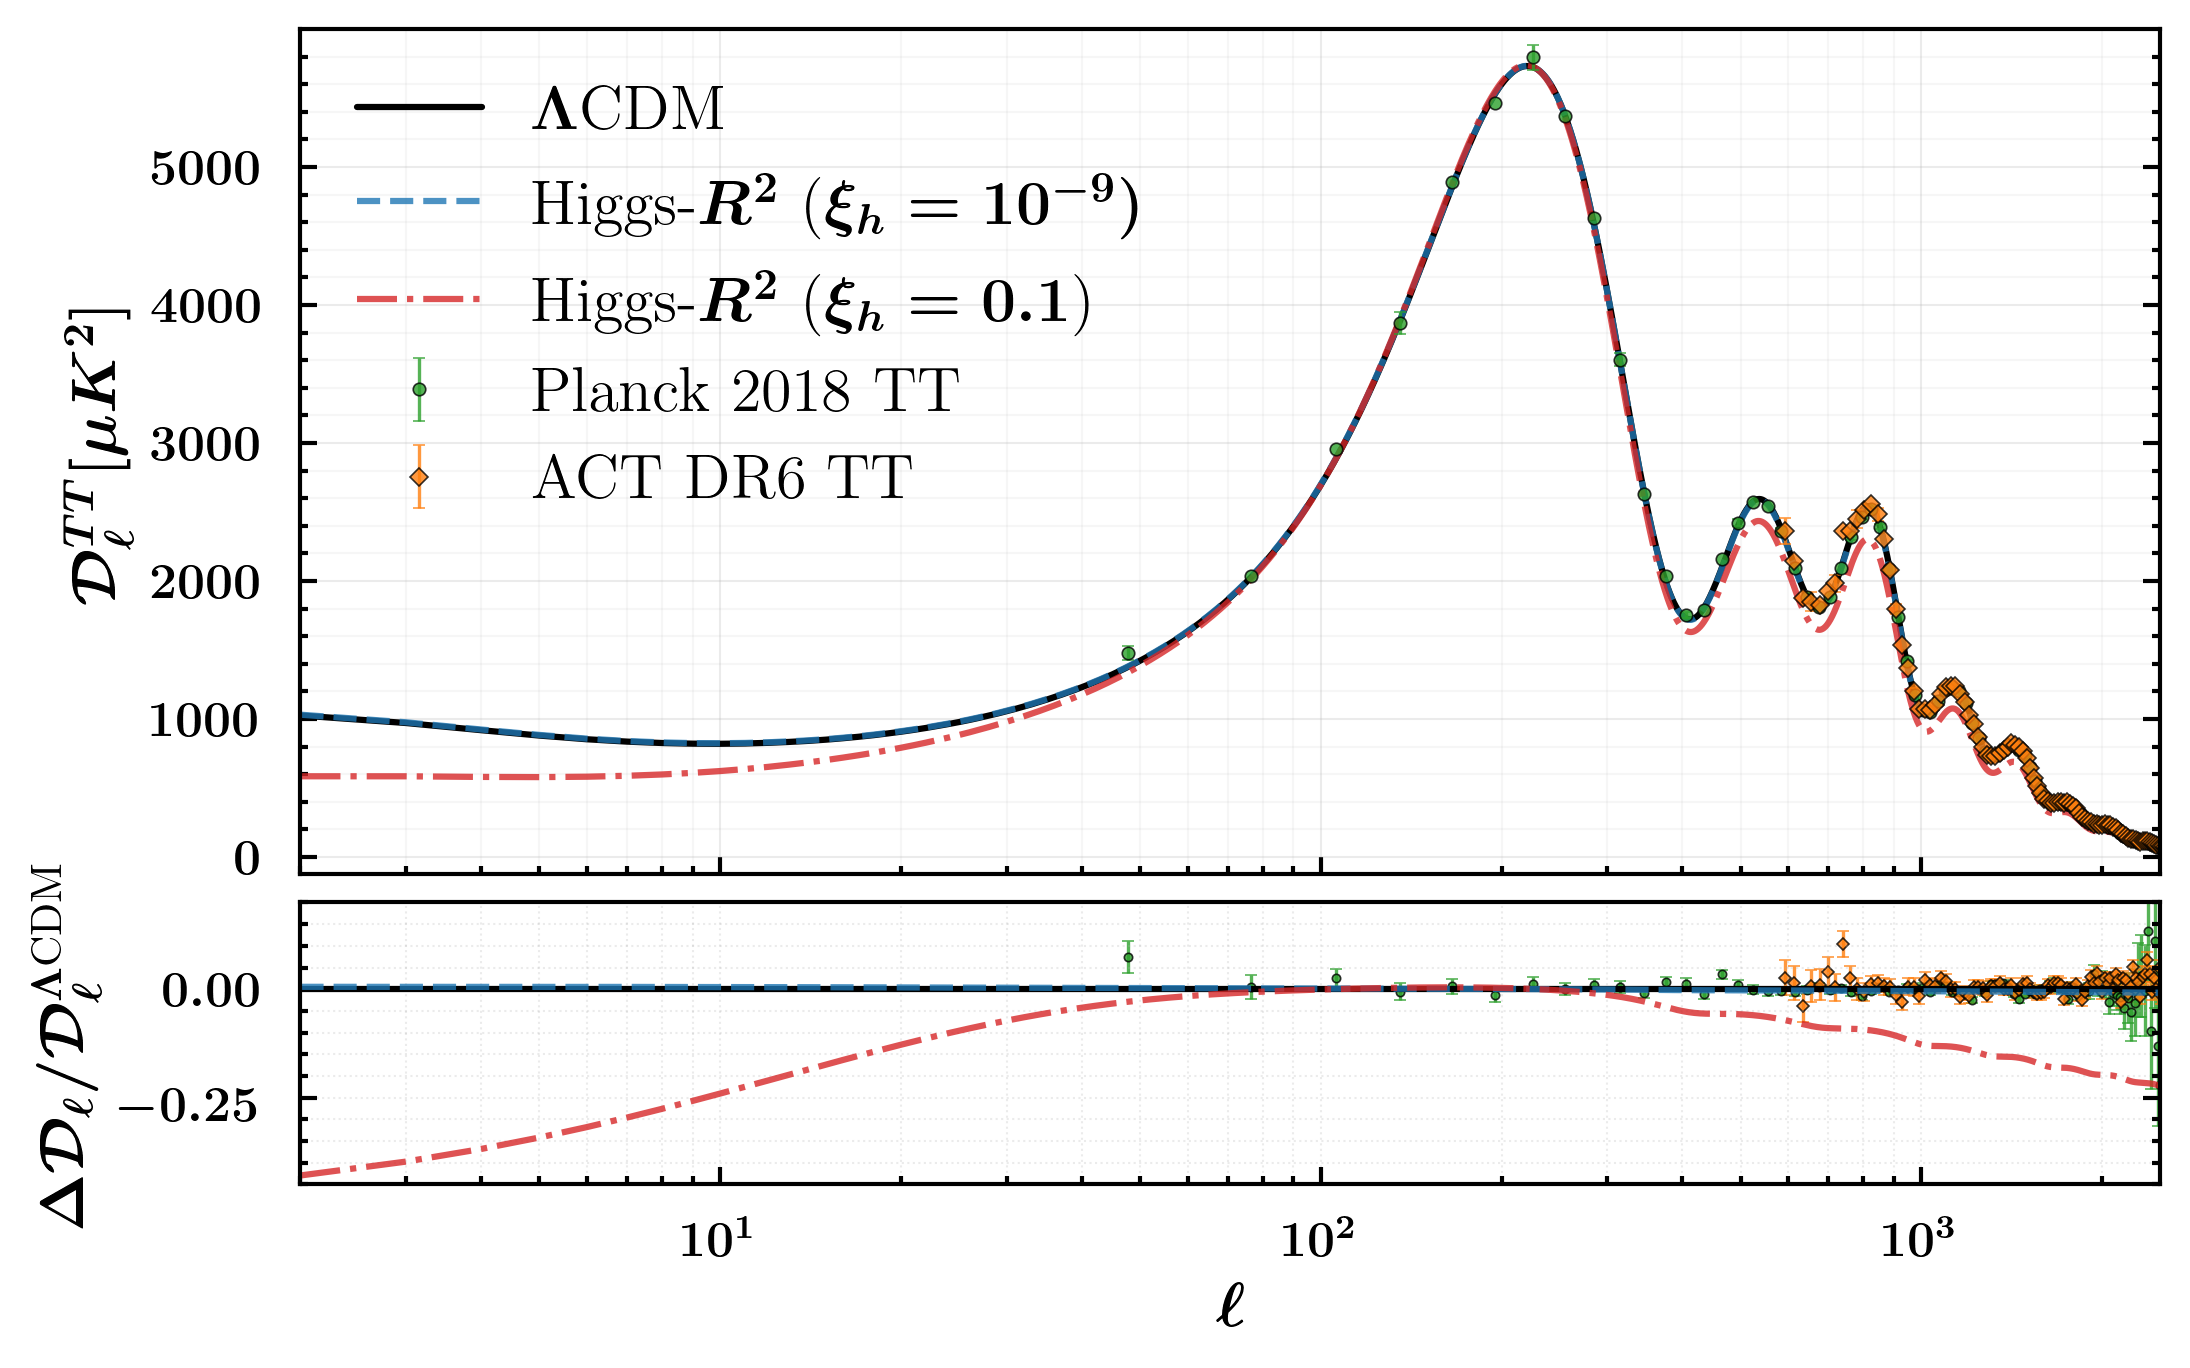

In [4]:

# --- 5. GRAFICAR ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

# --- PANEL SUPERIOR: Espectros Absolutos ---
# 1. Graficar Referencia LambdaCDM
ax1.plot(ll_ref, ref_data['tt'], 'k-', label=r'$\Lambda\text{CDM}$')



# 3. Graficar tus modelos Higgs-R^2
for label, datos in resultados.items():
    ax1.plot(datos['ll'], datos['tt'], 
             linestyle=datos['ls'], 
             label=label, alpha = 0.8)

# 2. GRAFICAR DATOS DE PLANCK (CORREGIDO USANDO ax1)
ax1.errorbar(
    ell,
    Dl_obs,
    yerr=[dDl_minus, dDl_plus],
    fmt='o',
    markersize=3,
    markeredgewidth=0.4,
    markeredgecolor='k',
    elinewidth=0.8,
    capsize= 1.5,
    capthick=0.8,
    alpha=0.8,
    errorevery=3,
    label="Planck 2018 TT",
    zorder=2
)


ax1.errorbar(
    ell_ACT,     
    dDl_ACT,       
    yerr= err_ACT,      
    fmt='D',       
    markersize=3,
    markeredgewidth=0.4,
    markeredgecolor='k',
    elinewidth=0.8,
    capsize=1.5,
    alpha=0.8,  
    errorevery=3,     
    label="ACT DR6 TT",
    zorder=2             
)

ax1.set_ylabel(r'$\mathcal{D}_\ell^{TT} [\mu K^2]$')
ax1.legend(loc='best')
ax1.set_xscale('log')
ax1.set_xlim(2, 2500)
ax1.grid(which='major', alpha=0.25)
ax1.grid(which='minor', alpha=0.10)

# --- PANEL INFERIOR: Residuos (Donde verás el fallo del modelo) ---
ax2.axhline(0, color='k', linestyle='-')

# Graficar residuos para cada modelo respecto a LambdaCDM
for label, datos in resultados.items():
    # Asegúrate de que ll coincide con ll_ref para la resta
    diff = (datos['tt'] - ref_data['tt']) / ref_data['tt']
    ax2.plot(datos['ll'], diff, linestyle=datos['ls'], alpha = 0.8)


diff_obs = (Dl_obs - np.interp(ell, ll_ref, ref_data['tt'])) / np.interp(ell, ll_ref, ref_data['tt'])
err_rel_minus = dDl_minus / np.interp(ell, ll_ref, ref_data['tt'])
err_rel_plus = dDl_plus / np.interp(ell, ll_ref, ref_data['tt'])

ax2.errorbar(ell, diff_obs, yerr=[err_rel_minus, err_rel_plus], 
             fmt='o', markersize=2, alpha=0.8, zorder=0,  markeredgewidth=0.4,
    markeredgecolor='k', elinewidth=0.8,   capsize= 1.5,
    capthick=0.8)

# NUEVO: Residuos de ACT respecto a la referencia (para ax2)
# Interpolamos la referencia a los puntos l de ACT
ref_en_ell_ACT = np.interp(ell_ACT, ll_ref, ref_data['tt'])
diff_ACT = (dDl_ACT - ref_en_ell_ACT) / ref_en_ell_ACT
err_rel_ACT = err_ACT / ref_en_ell_ACT

ax2.errorbar(ell_ACT, diff_ACT, yerr=err_rel_ACT, 
             fmt='D', markersize=2, alpha=0.8, 
             label="ACT DR6 Res.", zorder=0,  markeredgewidth=0.4,
    markeredgecolor='k', elinewidth=0.8,   capsize= 1.5,
    capthick=0.8)  
   

ax2.set_ylabel(r'$\Delta \mathcal{D}_\ell / \mathcal{D}_\ell^{\Lambda\text{CDM}}$')
ax2.set_xlabel(r'$\ell$')
ax2.set_ylim(-0.45, 0.2) 
ax2.minorticks_on()
ax2.grid(True, which='both', linestyle=':', alpha=0.25)
savefig('TT_angular_spectrum')


✅ Figura guardada en /Users/flaviopineda/Documents/Fisica/Proyectos/Paper/Figures/TE_angular_spectrum.pdf


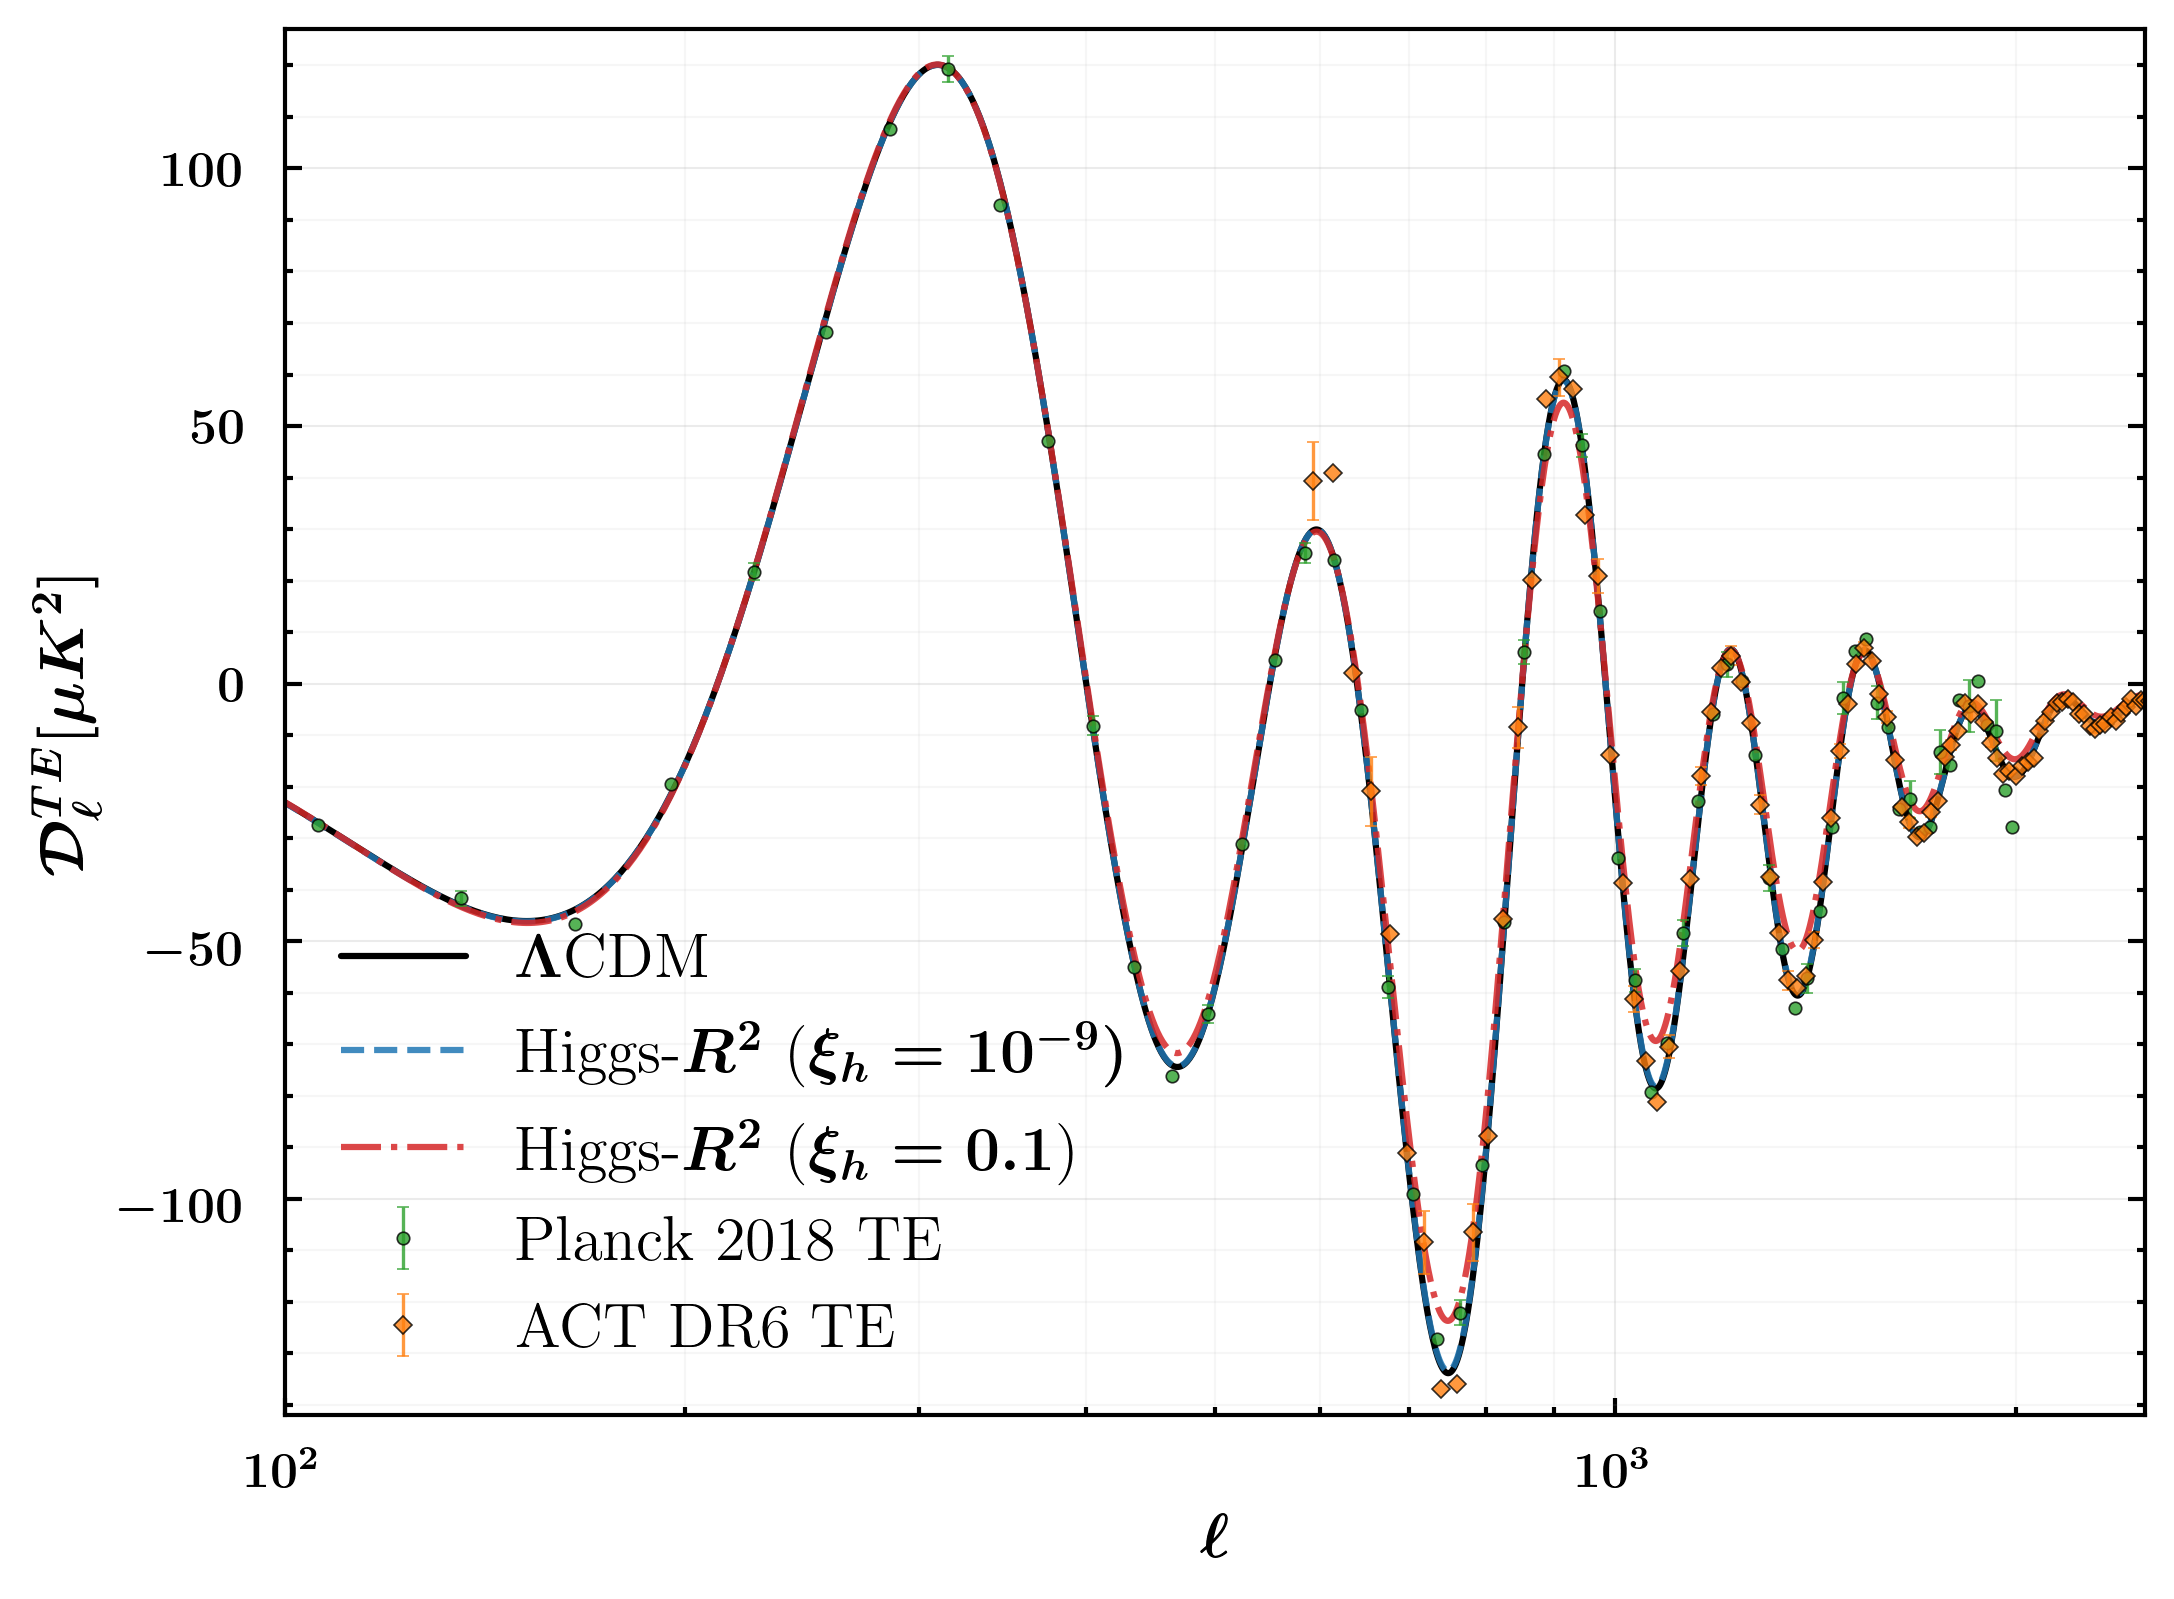

In [5]:
fig, ax = plt.subplots(figsize=(8, 6)) 

# 1. CORRECCIÓN EN LA LECTURA DE DATOS
# Asumiendo formato estándar Planck [l, Dl, err-, err+]
# Si tu archivo solo tiene 3 columnas, ajusta los índices.
data_TE = np.loadtxt("TE_binned.dat")
ell = data_TE[:, 0]
Dl_TE_obs = data_TE[:, 1]     # <--- ¡Faltaba leer el valor observado!
dDl_TE_minus = data_TE[:, 2]
dDl_TE_plus = data_TE[:, 3]

data_TE_ACT = np.loadtxt('ACT_TE.dat')
ell_ACT = data_TE_ACT[:,0]
Ddl_TE_ACT = data_TE_ACT[:,1]
err_TE_ACT = data_TE_ACT[:,2]


# 2. Graficar Referencia
ax.plot(ll_ref, ref_data['te'], 'k', label=r'$\Lambda\text{CDM}$')

# 3. Graficar tus modelos
for label, datos in resultados.items():
    ax.plot(datos['ll'], datos['te'], 
            linestyle=datos['ls'], 
            label=label, alpha=0.85)

# 4. CORRECCIÓN DEL ERRORBAR
# - Cambiado 'ax1' por 'ax'
# - Agregado 'Dl_TE_obs' como segundo argumento
ax.errorbar(
    ell,
    Dl_TE_obs,                # <--- Aquí va el eje Y
    yerr=[dDl_TE_minus, dDl_TE_plus],
    fmt='o',
    markersize=3,
    markeredgewidth=0.4,
    markeredgecolor='k',
    elinewidth=0.8,
    capsize= 1.5,
    capthick=0.8,
    alpha=0.8,
    errorevery=3,
    label="Planck 2018 TE",
    zorder=2
)


ax.errorbar(
    ell_ACT,
    Ddl_TE_ACT,                # <--- Aquí va el eje Y
    yerr=err_TE_ACT,
    fmt='D',
    markersize=3,
    markeredgewidth=0.4,
    markeredgecolor='k',
    elinewidth=0.8,
    capsize= 1.5,
    capthick=0.8,
    alpha=0.8,
    errorevery=3,
    label="ACT DR6 TE",
    zorder=2
)

# Etiquetas y Estilo
ax.set_ylabel(r'$\mathcal{D}_\ell^{TE} [\mu K^2]$')
ax.set_xlabel(r'$\ell$') 
ax.set_xlim(100, 2500)
ax.grid(which='major', alpha=0.25)
ax.grid(which='minor', alpha=0.10)

ax.legend(loc='best')
ax.set_xscale('log')
savefig('TE_angular_spectrum')


✅ Figura guardada en /Users/flaviopineda/Documents/Fisica/Proyectos/Paper/Figures/EE_angular_spectrum.pdf


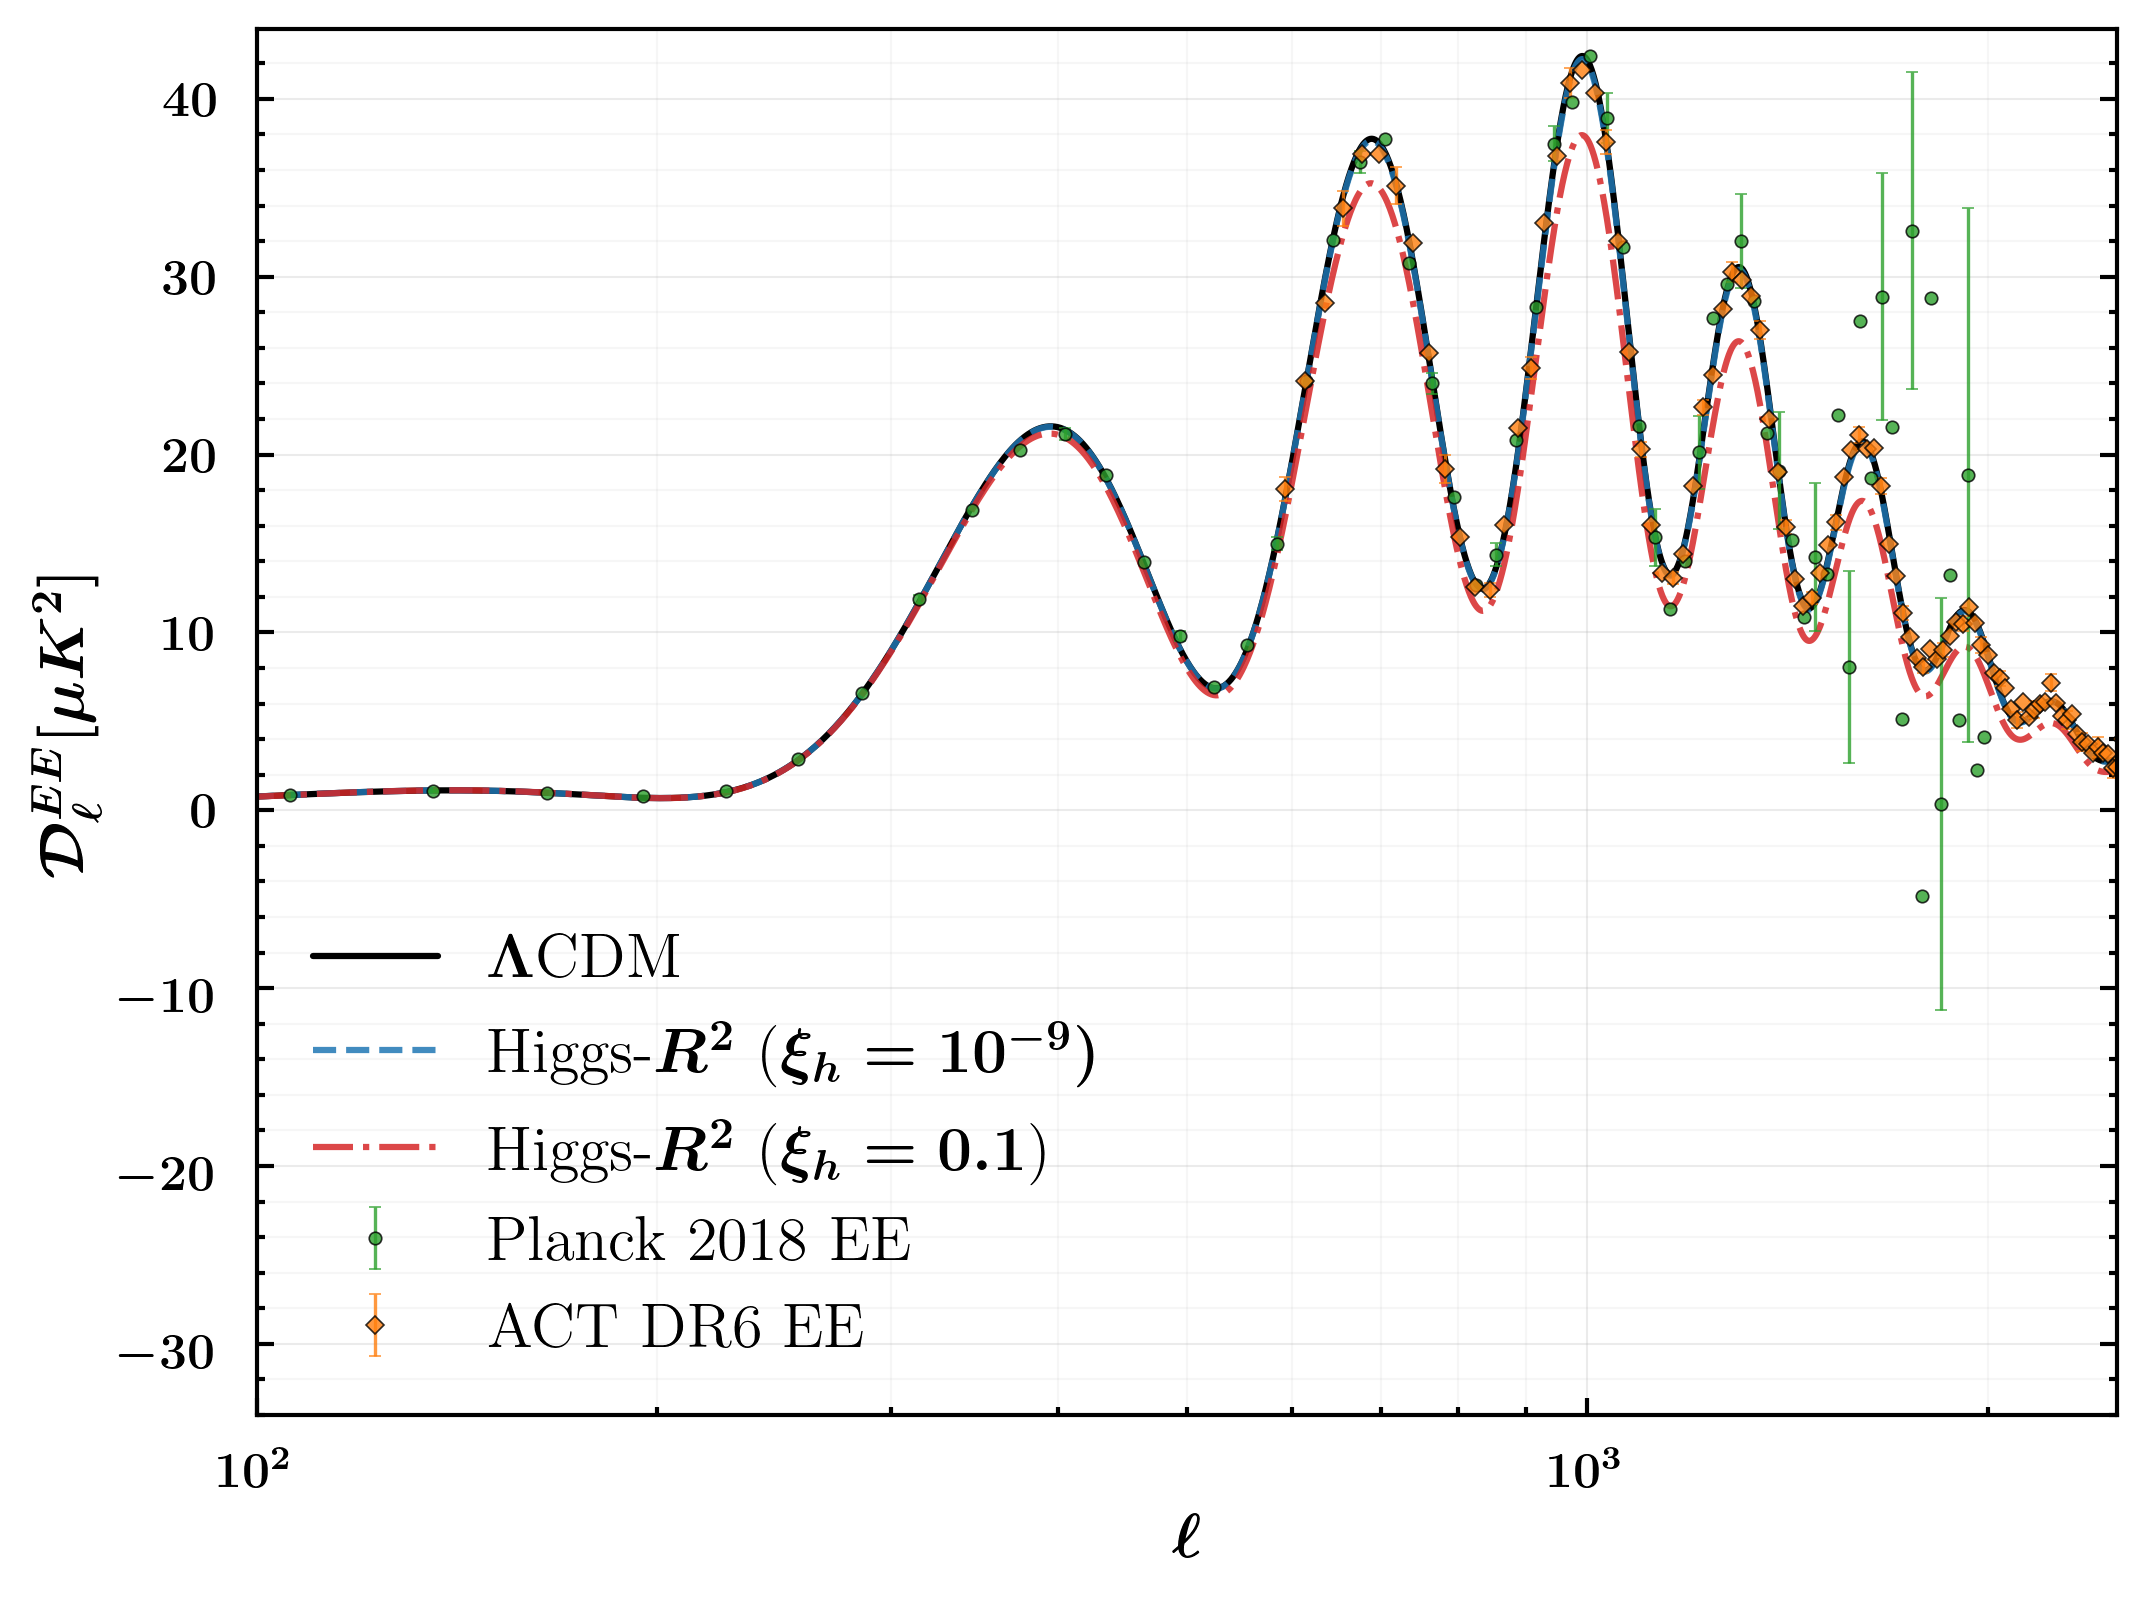

In [7]:
fig, ax = plt.subplots(figsize=(8, 6)) 

# 1. CORRECCIÓN EN LA LECTURA DE DATOS
# Asumiendo formato estándar Planck [l, Dl, err-, err+]
# Si tu archivo solo tiene 3 columnas, ajusta los índices.
data_EE = np.loadtxt("EE_binned.dat")
data
ell = data_EE[:, 0]
Dl_EE_obs = data_EE[:, 1]    
dDl_EE_minus = data_EE[:, 2]
dDl_EE_plus = data_EE[:, 3]


data_EE_ACT = np.loadtxt('ACT_EE.dat')
ell_ACT = data_EE_ACT[:,0]
Ddl_EE_ACT = data_EE_ACT[:,1]
err_EE_ACT = data_EE_ACT[:,2]

# 2. Graficar Referencia
ax.plot(ll_ref, ref_data['ee'], 'k', label=r'$\Lambda\text{CDM}$')

# 3. Graficar tus modelos
for label, datos in resultados.items():
    ax.plot(datos['ll'], datos['ee'], 
            linestyle=datos['ls'], 
            label=label, alpha=0.85)

# 4. CORRECCIÓN DEL ERRORBAR
# - Cambiado 'ax1' por 'ax'
# - Agregado 'Dl_TE_obs' como segundo argumento
ax.errorbar(
    ell,
    Dl_EE_obs,                # <--- Aquí va el eje Y
    yerr=[dDl_EE_minus, dDl_EE_plus],
    fmt='o',
    markersize=3,
    markeredgewidth=0.4,
    markeredgecolor='k',
    elinewidth=0.8,
    capsize= 1.5,
    capthick=0.8,
    alpha=0.8,
    errorevery=3,
    label="Planck 2018 EE",
    zorder=2
)


ax.errorbar(
    ell_ACT,
    Ddl_EE_ACT,                
    yerr=err_EE_ACT,
    fmt='D',
    markersize=3,
    markeredgewidth=0.4,
    markeredgecolor='k',
    elinewidth=0.8,
    capsize= 1.5,
    capthick=0.8,
    alpha=0.8,
    errorevery=3,
    label="ACT DR6 EE",
    zorder=2
)

# Etiquetas y Estilo
ax.set_ylabel(r'$\mathcal{D}_\ell^{EE} [\mu K^2]$')
ax.set_xlabel(r'$\ell$') 
ax.set_xlim(100, 2500)
ax.grid(which='major', alpha=0.25)
ax.grid(which='minor', alpha=0.10)

ax.legend(loc='best')
ax.set_xscale('log')
savefig('EE_angular_spectrum')
